In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import jax.numpy as jnp
from jax import grad, vmap
import jax
import jax.random as jrandom
import matplotlib.pyplot as plt
from utils import prepare_data
from models import *
from advi import *

## Toy Regression

In [27]:
N = 100
d = 30
key = jrandom.key(42)
k1, k2, k3 = jrandom.split(key, 3)
X_data = jrandom.normal(k1, shape=(N, d))
w_star = jrandom.normal(k2, shape=(d,)) * 2
y = X_data @ w_star
linear_model = LinearModel(X_data, y, 1, 1)
linear_advi = mean_field_advi(linear_model)
key = jrandom.key(52)


In [36]:
linear_advi = mean_field_advi(linear_model)
loss_1_adaptive = linear_advi.run_advi(
    key, 1, 1001, 1e-3, print_every=500, adaptive=True, alpha=0.5
)
linear_advi = mean_field_advi(linear_model)

loss_1_fixed = linear_advi.run_advi(
    key, 1, 1001, 1e-4, print_every=500, adaptive=False, alpha=0.5
)

linear_advi = mean_field_advi(linear_model)

loss_10_adaptive = linear_advi.run_advi(
    key, 10, 1001, 1e-3, print_every=500, adaptive=True, alpha=0.5
)
linear_advi = mean_field_advi(linear_model)

loss_10_fixed = linear_advi.run_advi(
    key, 10, 1001, 1e-4, print_every=500, adaptive=False, alpha=0.5
)

-24716.01
-9773.578
-128050.98
-24716.01
-458.5725
-440.31818
-12223.118
-12937.918
-6487.828
-12223.118
-459.52545
-450.9148


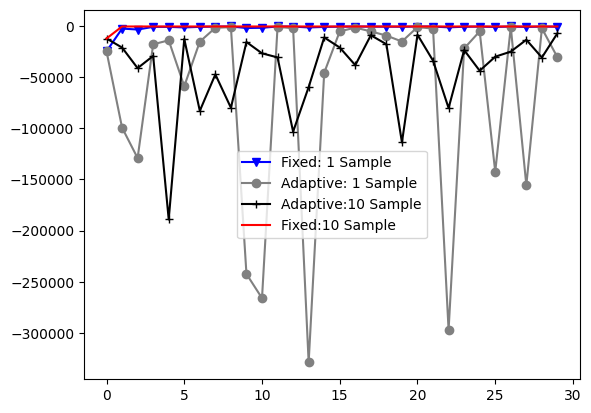

In [38]:
plt.plot(loss_1_fixed[:30], label='Fixed: 1 Sample', color='blue', marker="v")
plt.plot(loss_1_adaptive[:30], label='Adaptive: 1 Sample', marker='o', color='grey')
plt.plot(loss_10_adaptive[:30], label='Adaptive:10 Sample', marker='+', color='black')
plt.plot(loss_10_fixed[:30], label='Fixed:10 Sample',color='red')
plt.legend( loc='lower right')
plt.savefig("toy_adapt_fixed2.pdf")

# plt.savefig("toy_samples.pdf")

## HLR Experiments

In [40]:
k = jrandom.key(42)
beta_prior = 100
alpha_prior = 1
data = prepare_data()
hlr_model = HLR_Model(data,alpha_prior=1)
hlr_advi = mean_field_advi(hlr_model)
# loss = hlr_advi.run_advi(
#     k, 3, 10001, 1e-5, print_every=100, adaptive=False, alpha=0.5
# )

hlr_advi = mean_field_advi(hlr_model)

loss_1_fixed = hlr_advi.run_advi(
    key, 1, 10001, 1e-5, print_every=5000, adaptive=False, alpha=0.5
)
hlr_advi = mean_field_advi(hlr_model)

loss_1_adaptive = hlr_advi.run_advi(
    key, 1, 10001, 1e-4, print_every=5000, adaptive=True, alpha=0.5
)

hlr_advi = mean_field_advi(hlr_model)
loss_10_fixed = hlr_advi.run_advi(
    key, 10, 10001, 1e-5, print_every=5000, adaptive=False, alpha=0.5
)
hlr_advi = mean_field_advi(hlr_model)
loss_10_adaptive = hlr_advi.run_advi(
    key, 10, 10001, 1e-4, print_every=5000, adaptive=True, alpha=0.5
)


-12487.868
-7678.4243
-7656.96
-12487.868
-23242.734
-16432.178
-16522.125
-7658.9814
-7651.225
-16522.125
nan
nan


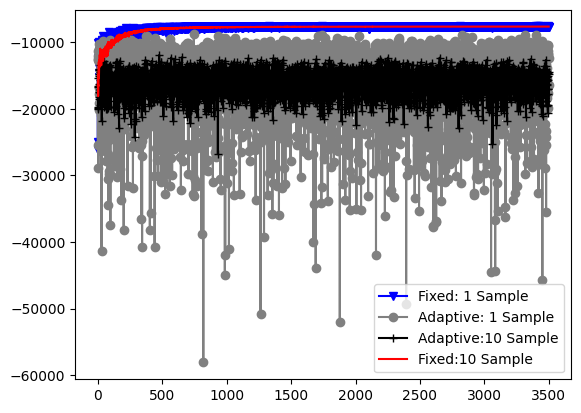

In [43]:
plt.plot(loss_1_fixed[:3500], label='Fixed: 1 Sample', color='blue', marker="v")
plt.plot(loss_1_adaptive[:3500], label='Adaptive: 1 Sample', marker='o', color='grey')
plt.plot(loss_10_adaptive[:3500], label='Adaptive:10 Sample', marker='+', color='black')
plt.plot(loss_10_fixed[:3500], label='Fixed:10 Sample',color='red')
plt.legend()
plt.savefig("new_hlr_adapt.pdf")
# plt.savefig("toy_adapt_fixed.pdf")

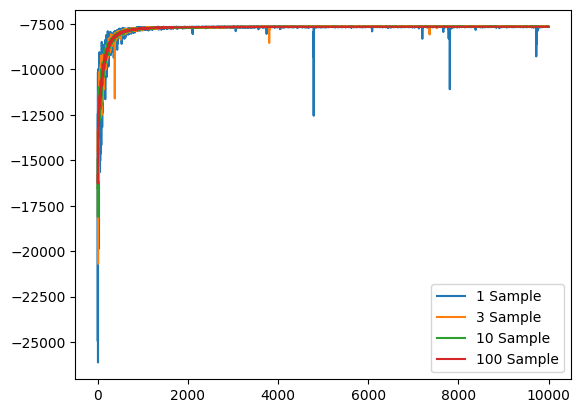

In [54]:
plt.plot((jnp.array(loss_1)), label='1 Sample')
plt.plot((jnp.array(loss_3)), label='3 Sample')
plt.plot((jnp.array(loss_10)), label='10 Sample')
plt.plot((jnp.array(loss_100)), label='100 Sample')
plt.legend()
# plt.ylabel("ELBO")
# plt.show()
plt.savefig("hlr_sample.pdf")
# plt.yscale('log')  # Set y-axis to logarithmic scale

In [50]:
mu = hlr_advi.params['mu']
sigma = hlr_advi.params['sigma']
beta, alpha_age, alpha_regions, alpha_edu, alpha_age_edu = hlr_advi.model.t_inv_map(mu)
var_beta, var_alpha_age, var_alpha_regions, var_alpha_edu, var_alpha_age_edu = hlr_advi.model.t_inv_map(sigma)

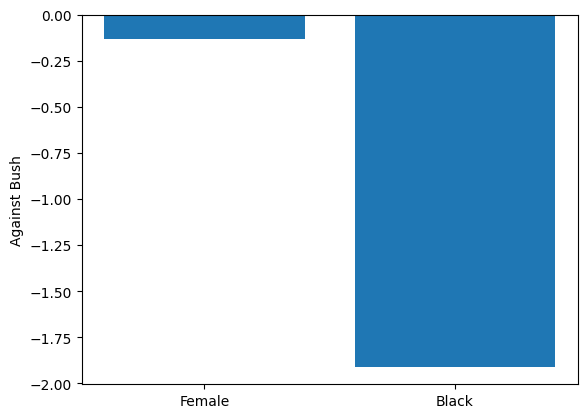

In [55]:
# northeast, south, north_central, 4=west, 5=d.c.
plt.bar(x=["Female", "Black"], height=beta[1:3])
plt.ylabel("Against Bush")
plt.savefig("female_black.pdf")
plt.show()


Text(0, 0.5, 'Voting Democrate')

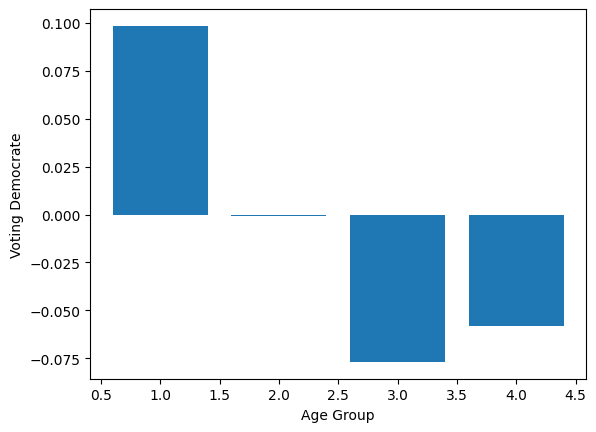

In [36]:
plt.bar(x=range(1,5),height=alpha_age)
plt.xlabel("Age Group")
plt.ylabel("Prediction Correction (for Bush)")

Text(0, 0.5, 'Democrate Voting')

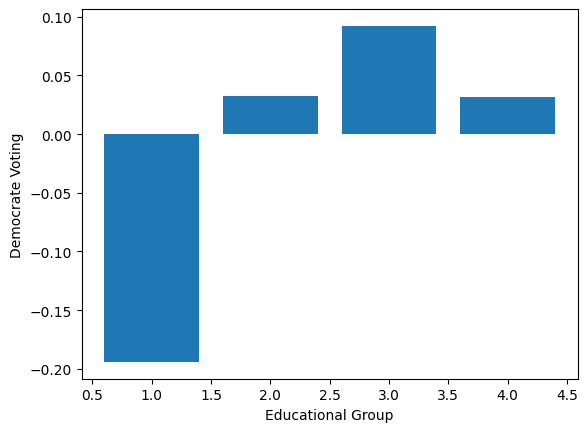

In [37]:

plt.bar(x=range(1,5),height=alpha_edu)
plt.xlabel("Educational Group")
plt.ylabel("Democrate Voting")

## Faces Experiments 

In [ ]:
from scipy.io import loadmat

all_data = loadmat("data/frey_rawface.mat")
data = all_data["ff"].T[:100]

In [ ]:
rank = 10
nmf_model = NMF_Model_PoissonGamma(data, rank, gamma_prior_shape=1, gamma_prior_scale=1)
nmf_dim = nmf_model.dim
k = jrandom.key(15)
trial_vec = jrandom.normal(k, shape=(nmf_dim,))
theta, beta = nmf_model.t_inv_map(trial_vec)
nmf_advi = mean_field_advi(nmf_model)
nmf_advi.run_advi(k, 10, 10001, 1e-5, print_every=500, adaptive=False)


thetas, betas = nmf_model.t_inv_map(nmf_advi.params["mu"])

u = 42
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(betas[i].reshape(28, 20), cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(rf"$\beta_{{{i}}}$")

In [ ]:
rank = 10
nmf_model = NMF_Model_PoissonDirExp(data, rank)
nmf_dim = nmf_model.dim
k = jrandom.key(15)
trial_vec = jrandom.normal(k, shape=(nmf_dim,))
theta, beta = nmf_model.t_inv_map(trial_vec)
nmf_advi = mean_field_advi(nmf_model)
nmf_advi.run_advi(k, 10, 10001, 1e-5, print_every=100, adaptive=True)


thetas, betas = nmf_model.t_inv_map(nmf_advi.params["mu"])

u = 42
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(betas[i].reshape(28, 20), cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(rf"$\beta_{{{i}}}$")

In [ ]:
u = 25
plt.figure()
plt.subplot(121)
plt.imshow((thetas[u] @ betas).reshape(28, 20), cmap="gray")
plt.axis("off")
plt.title(rf"$\theta_{{{u}}}\cdot\beta$")
plt.subplot(122)
plt.imshow((data[u]).reshape(28, 20), cmap="gray")
plt.title(rf"$Y_{{{u}, true}}$")
plt.axis("off")
print(f"theta_{u}: {thetas[u]}")